In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import pandas as pd

In [3]:
rating_df = pd.read_csv('./data/rating_data.csv')
rating_df

,user,item,rating
0,0,12789,2.0
1,0,12790,5.0
2,0,12791,5.0
3,0,12792,5.0
4,0,12793,5.0
...,...,...,...
356662,12770,19494,5.0
356663,12770,14287,5.0
356664,12770,31360,5.0
356665,12770,15691,5.0


In [4]:
u = rating_df['user'].values
i = rating_df['item'].values
g = dgl.graph((u, i))
g

Graph(num_nodes=35914, num_edges=356667,
      ndata_schemes={}
      edata_schemes={})

In [38]:
type(g)

dgl.heterograph.DGLHeteroGraph

In [39]:
g.nodes()

tensor([    0,     1,     2,  ..., 35911, 35912, 35913])

In [40]:
g.edges()

(tensor([    0,     0,     0,  ..., 12770, 12770, 12770]),
 tensor([12789, 12790, 12791,  ..., 31360, 15691, 33555]))

In [42]:
type(g)

dgl.heterograph.DGLHeteroGraph

In [45]:
G = dgl.to_bidirected(g)
G

Graph(num_nodes=35914, num_edges=713334,
      ndata_schemes={}
      edata_schemes={})

In [48]:
G.number_of_nodes()

35914

In [50]:
G.ndata['feature'] = torch.randn((G.number_of_nodes(), 10))
G.ndata

{'feature': tensor([[-1.3591,  0.7882,  1.3617,  ..., -0.8448,  0.4306,  0.6892],
        [ 1.2128, -0.7209, -0.6470,  ..., -1.2631,  0.2141, -0.5701],
        [ 0.2180,  0.5105, -0.6881,  ...,  0.2324,  1.6044,  0.2483],
        ...,
        [ 0.6904,  0.3798, -1.0947,  ..., -0.5926, -1.3826, -0.4642],
        [-1.6314,  0.2743, -0.2968,  ..., -0.1462, -0.9196,  0.1446],
        [-0.1339, -0.3456, -0.3229,  ..., -1.7770,  0.1777,  0.4236]])}

In [58]:
g.ndata['feature'] = torch.randn((g.number_of_nodes(), 10))
g.ndata['feature'].__len__()

35914

In [54]:
u, v = g.edges()
u, v

(tensor([    0,     0,     0,  ..., 12770, 12770, 12770]),
 tensor([12789, 12790, 12791,  ..., 31360, 15691, 33555]))

In [12]:
import dgl.nn.pytorch as dglnn
conv = dglnn.GraphConv(10, 5, weight=True, bias=True,allow_zero_in_degree=True)
conv

GraphConv(in=10, out=5, normalization=both, activation=None)

In [86]:
u

(tensor([    0,     0,     0,  ..., 12770, 12770, 12770]),
 torch.Size([356667]))

In [89]:
g.nodes(), g.nodes().shape

(tensor([    0,     1,     2,  ..., 35911, 35912, 35913]), torch.Size([35914]))

In [71]:
(g.in_degrees() != 0).sum()

tensor(23143)

In [72]:

(g.out_degrees() != 0).sum()

tensor(12771)

In [ ]:
h = conv(G, G.ndata['feature'])
h,h.shape

In [5]:
u1 = torch.tensor([0, 0, 1, 2, 3, 3, 4])
i = torch.tensor([0, 1, 1, 2, 2, 3, 3])
u2 = torch.tensor([1, 2, 3, 4, 0, 2, 0])
social_u = torch.cat([u1, u2])
social_v = torch.cat([u2, u1])
graph_data = {
    ('user', 'rate', 'item'): (u1, i),
    ('item', 'rated', 'user'): (i, u1),
    ('user', 'friend', 'user'): (social_u, social_v)
}
g = dgl.heterograph(graph_data)

In [6]:
g.nodes('user'), g.nodes('item')

(tensor([0, 1, 2, 3, 4]), tensor([0, 1, 2, 3]))

In [7]:
g.num_nodes('user')

5

In [8]:
g.number_of_nodes('user')

5

In [23]:
embedding_size = 2
torch.arange(g.number_of_nodes('user') * 2).reshape(-1, embedding_size)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [26]:
embedding_size = 2
u_feat = torch.arange(g.number_of_nodes('user') * 2, dtype=torch.float).reshape(-1, embedding_size)
i_feat = torch.arange(g.number_of_nodes('item') * 2, dtype=torch.float).reshape(-1, embedding_size)
u_feat, i_feat

(tensor([[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.],
         [8., 9.]]),
 tensor([[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]))

In [27]:
g.nodes['user'].data['feat'] = u_feat
g.nodes['item'].data['feat'] = i_feat
g.nodes['user'], g.nodes['item']

(NodeSpace(data={'feat': tensor([[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.],
         [8., 9.]])}),
 NodeSpace(data={'feat': tensor([[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]])}))

In [30]:
hetero_conv = dglnn.HeteroGraphConv({
    'rate': dglnn.GraphConv(2, 1),
    'rated': dglnn.GraphConv(2, 1),
    'friend': dglnn.GraphConv(2, 1),
},aggregate='sum')

In [31]:
f1 = {'user': g.nodes['user'].data['feat'], 'item': g.nodes['item'].data['feat']}
h = hetero_conv(g, f1)
h

{'item': tensor([[-0.2772],
         [-1.8345],
         [-6.0837],
         [-8.8064]], grad_fn=<SumBackward1>),
 'user': tensor([[ 4.7661],
         [ 4.5242],
         [ 8.0422],
         [12.9272],
         [10.7382]], grad_fn=<SumBackward1>)}

In [19]:
h2 = hetero_conv(g, h)
h2

{'item': tensor([[-1.1357, -0.5318,  0.3137,  0.6778,  0.0732, -0.2691,  0.0968,  0.1155,
          -0.3612,  0.4361],
         [-1.1014, -0.2654,  0.6500,  0.5481,  0.1637, -0.2777, -0.2936,  0.3639,
          -0.4927,  0.3998],
         [-0.9510, -0.1286,  0.5141, -0.0957, -0.2745, -0.1442, -0.1466,  0.3496,
          -0.4195,  0.6651],
         [-0.4313,  0.6137, -0.0250, -0.7428, -0.4775, -0.2846,  0.5751, -0.3867,
          -0.1668,  0.6979]], grad_fn=<MeanBackward1>),
 'user': tensor([[ 0.6444, -0.2259,  0.1939, -0.2623, -0.0967,  0.0060, -0.2984, -0.2726,
          -0.1794, -0.0780],
         [ 0.3270,  0.0486,  0.1125,  0.2078,  0.0197, -0.1133, -0.2519, -0.2449,
          -0.1267, -0.0035],
         [ 0.1137,  0.0672, -0.1859, -0.8432,  0.5712,  0.0975, -0.6889, -0.2168,
          -0.4625, -1.3323],
         [ 0.0180,  0.2996,  0.0924, -0.4162,  0.3819, -0.0808, -0.4965, -0.7213,
          -0.4698, -1.1969],
         [-0.1059,  0.0320,  0.3418,  0.0664,  0.0850, -0.3383, -0.02

In [63]:
def agg_func(tensors, dsttype):
    print(tensors, dsttype)
    if dsttype == 'user':
        return tensors[0]
    else:
        return tensors[0]

test_conv = dglnn.HeteroGraphConv({
    'rate': dglnn.GraphConv(2, 2, weight=False, bias=False),
    'rated': dglnn.GraphConv(2, 2, weight=False, bias=False),
    'friend': dglnn.GraphConv(2, 2, weight=False, bias=False),
}, aggregate=agg_func)

In [71]:
i = {'item': g.nodes['item'].data['feat']}
u = {'user': g.nodes['user'].data['feat']}
u1 = test_conv(g, (i, u))
i1 = test_conv(g, (u, i))
u1, i1
# h2 = test_conv(g, h1)
# h2

[tensor([[1.0000, 2.2071],
        [1.4142, 2.1213],
        [2.8284, 3.5355],
        [5.0000, 6.0000],
        [4.2426, 4.9497]])] user
[tensor([[0.0000, 0.7071],
        [1.4142, 2.6213],
        [5.8284, 7.0355],
        [8.6569, 9.8640]])] item


({'user': tensor([[1.0000, 2.2071],
          [1.4142, 2.1213],
          [2.8284, 3.5355],
          [5.0000, 6.0000],
          [4.2426, 4.9497]])},
 {'item': tensor([[0.0000, 0.7071],
          [1.4142, 2.6213],
          [5.8284, 7.0355],
          [8.6569, 9.8640]])})

In [68]:
mlp = nn.Linear(4, 2)
a = torch.randn(4, 4)
mlp(a)

tensor([[-0.3489,  0.3558],
        [-0.0841, -0.6679],
        [ 0.5668,  0.8656],
        [ 0.5264,  0.3434]], grad_fn=<AddmmBackward0>)

In [65]:
mlp = nn.Linear(4, 2)
def agg_func_1(tensors, dsttype):
    print(tensors, dsttype)
    if dsttype == 'user':
        tmp = torch.hstack(tensors)
        return mlp(tmp)
    else:
        raise ValueError('Wrong DstType!!!')

test_conv2 = dglnn.HeteroGraphConv({
    'rate': dglnn.GraphConv(2, 2, weight=False, bias=False),
    'rated': dglnn.GraphConv(2, 2, weight=False, bias=False),
    'friend': dglnn.GraphConv(2, 2, weight=False, bias=False),
}, aggregate=agg_func_1)

In [70]:
rsc = {'user': u1['user'], 'item': i1['item']}
dst = {'user': u1['user']}
u1 = test_conv2(g, (rsc, dst))
u1

[tensor([[0.7071, 1.8107],
        [1.0000, 1.8536],
        [4.1213, 4.9749],
        [7.2426, 8.4497],
        [6.1213, 6.9749]]), tensor([[4.2599, 5.2527],
        [2.3948, 3.2298],
        [3.6874, 4.6579],
        [1.8088, 2.6817],
        [1.5083, 2.2237]])] user


{'user': tensor([[0.7071, 1.8107],
         [1.0000, 1.8536],
         [4.1213, 4.9749],
         [7.2426, 8.4497],
         [6.1213, 6.9749]])}

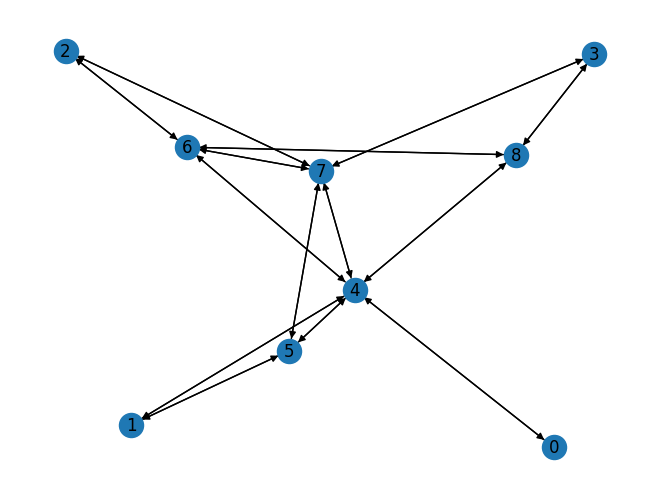

In [154]:
import networkx as nx
import matplotlib.pyplot as plt
nx.draw(dgl.to_homogeneous(g).to_networkx(), with_labels=True)
plt.show()

In [157]:
dgl.to_homogeneous(g).ndata

{'_ID': tensor([0, 1, 2, 3, 0, 1, 2, 3, 4]), '_TYPE': tensor([0, 0, 0, 0, 1, 1, 1, 1, 1])}

In [158]:
dgl.to_homogeneous(g).edata

{'_ID': tensor([ 0,  1,  2,  3,  4,  5,  6,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13,  0,  1,  2,  3,  4,  5,  6]), '_TYPE': tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2])}

In [155]:
dgl.to_homogeneous(g).edges()

(tensor([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 6, 7, 7, 8, 5, 6, 7, 8, 4, 6, 4, 4, 4, 5,
         6, 7, 7, 8]),
 tensor([4, 4, 5, 6, 7, 7, 8, 5, 6, 7, 8, 4, 6, 4, 4, 4, 5, 6, 7, 7, 8, 0, 1, 1,
         2, 2, 3, 3]))

In [164]:
G = dgl.to_homogeneous(g, ndata=['feat'])
G.ndata['feat'], G.ndata['feat'].shape

(tensor([[-1.3626,  1.2295,  0.1833, -0.3301,  1.2184, -0.9155,  0.3534, -1.3819,
          -0.3655,  2.0767],
         [ 0.8387,  0.7305,  0.0173,  0.9697, -0.0603,  1.1364,  1.6625, -0.3281,
          -0.3580, -0.0627],
         [-0.5409, -1.1335,  0.5510,  1.5634, -0.7772, -0.5340,  0.6385, -0.9435,
          -0.7112, -0.4917],
         [ 0.9065, -1.2236, -0.1256,  0.7899,  1.5102, -0.0177, -1.7075, -0.9670,
           0.0923,  0.1513],
         [-1.2779, -0.9226,  1.6277, -0.6378,  0.5067,  0.5687, -0.2115, -1.2798,
           1.5252,  0.0067],
         [ 0.3077, -0.3240, -0.6852,  1.6926, -1.2951,  1.3879,  0.5503, -0.1486,
          -0.0811,  2.0101],
         [ 0.2216,  1.0301,  0.2420,  1.0698, -0.2145, -0.5317, -0.1958,  0.8136,
           1.0720, -0.4424],
         [-0.0395,  1.3079, -1.0916, -0.2716,  1.1112, -0.6924, -1.1884, -0.2949,
           0.9796, -0.5803],
         [ 2.1415, -2.3012,  1.7676,  1.1618, -0.1146,  0.1136,  1.5060, -0.1088,
           0.7253,  1.0259]]),

In [165]:
conv = dglnn.GraphConv(10, 5)
h = conv(G, G.ndata['feat'])
h

tensor([[ 3.3386e-01, -5.2626e-01,  2.0961e-01,  7.1263e-02, -2.7464e-01],
        [ 3.5958e-01, -2.6569e-04,  5.1686e-01, -1.8987e-01, -1.8596e-01],
        [ 6.5542e-01, -7.2885e-01,  3.4133e-01,  4.8400e-01, -1.8278e-01],
        [ 2.1736e-01, -2.4449e-01,  2.7024e-01,  2.0027e-01,  4.8628e-01],
        [ 1.4340e+00,  1.0552e-01, -6.9705e-01, -2.0708e-01, -8.0298e-01],
        [ 3.5023e-01, -2.9600e-01, -1.5737e-01, -5.8521e-02, -2.8541e-01],
        [ 2.7351e-01, -7.8336e-01,  8.4595e-01,  3.1757e-01,  1.2777e-01],
        [ 3.4492e-01, -8.0888e-01,  1.4450e+00,  2.5568e-01, -7.1913e-02],
        [ 3.9887e-01, -9.4679e-01,  9.2937e-01,  3.6421e-01, -8.6233e-03]],
       grad_fn=<AddBackward0>)